In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
tf.__version__

'1.12.0'

In [3]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

mnist


In [4]:
#from python-mnist import MNIST
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('./model_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./model_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./model_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./model_data/t10k-images-idx3-ubyte.gz
Extracting ./model_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Validation-set:\t{}".format(len(data.test.labels)))
print("- Test-set:\t\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Validation-set:	10000
- Test-set:		5000


In [6]:
data.test.cls = np.argmax(data.test.labels, axis=1)

In [7]:
img_size = 28

img_size_flat = 28*28

img_shape = (img_size,img_size)

num_channels = 1

num_classes = 10

In [8]:
#helper function to plot images
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    #create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred {1}".format(cls_true[i], cls_pred)

array([7, 2, 1, 0, 4, 1, 4, 9, 5])

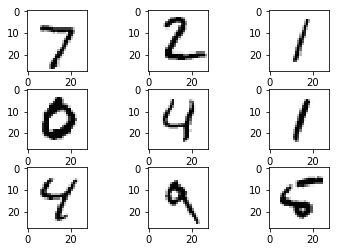

In [9]:
images = data.test.images[0:9]

cls_true = data.test.cls[0:9]

plot_images(images=images, cls_true=cls_true)
cls_true

In [10]:
#initializing graph with random weights
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(shape):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [11]:
#helper function to create new CNN layer as tensorflow is complicated
def new_conv_layer(input,  #prev layer
                   num_input_channels, #n channels from prev layer
                   filter_size,        #width and height
                   num_filters,
                   use_pooling=True    #use 2x2 max pooling
                  ):
    #shape of filter weights for conv
    #this format determined by TensorFlow API
    shape = [filter_size, filter_size,num_input_channels, num_filters]
    
    weights = new_weights(shape=shape)
    
    biases = new_biases(length=num_filters)
    
    layer = tf.nn.conv2d(input=input, 
                        filter=weights,
                        strides=[1,1,1,1],
                        padding='SAME')
    layer += biases
    
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                              ksize=[1,2,2,1],
                              strides=[1,2,2,1],
                              padding='SAME')
    
    layer = tf.nn.relu(layer)
    
    return layer, weights

In [14]:
def flatten_layer(layer):

    layer_shape = layer.get_shape()
    
    num_features = np.array(layer_shape[1:4], dtype=int).prod()
    
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features
    

In [16]:
def new_fc_layer(input, 
                num_inputs,
                num_outputs,
                use_relu=True):
    weights=new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
        
    return layer

In [17]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [19]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])